In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import time
from datetime import date
import random
from tensorflow.keras.utils import plot_model

In [2]:
# Прочитали файл с американским ВВП
%time gdp = pd.read_csv(r"C:\Users\shuva\Downloads\GDP.csv")
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp.info()
gdp.head()

CPU times: total: 0 ns
Wall time: 2.48 ms
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    306 non-null    datetime64[ns]
 1   GDP     306 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.9 KB


,DATE,GDP
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


In [3]:
# Прочитали файл с американской М2
m2 = pd.read_csv(r"C:\Users\shuva\Downloads\M2SL.csv")
m2['DATE'] = pd.to_datetime(m2['DATE'])
m2['M2SL'] = pd.to_numeric(m2['M2SL'],errors='coerce')
m2 = m2.dropna()
m2.info()
m2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    258 non-null    datetime64[ns]
 1   M2SL    258 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.0 KB


,DATE,M2SL
0,1959-01-01,289.2
1,1959-04-01,294.1
2,1959-07-01,296.7
3,1959-10-01,297.8
4,1960-01-01,299.3


In [4]:
# merge two files
df = pd.merge(gdp, m2, on='DATE')
print(df.head())
print(df.tail())

        DATE      GDP   M2SL
0 1959-01-01  510.330  289.2
1 1959-04-01  522.653  294.1
2 1959-07-01  525.034  296.7
3 1959-10-01  528.600  297.8
4 1960-01-01  542.648  299.3
          DATE        GDP     M2SL
253 2022-04-01  25248.476  21666.4
254 2022-07-01  25723.941  21525.2
255 2022-10-01  26137.992  21357.6
256 2023-01-01  26529.774  20876.1
257 2023-04-01  26798.605  20890.0


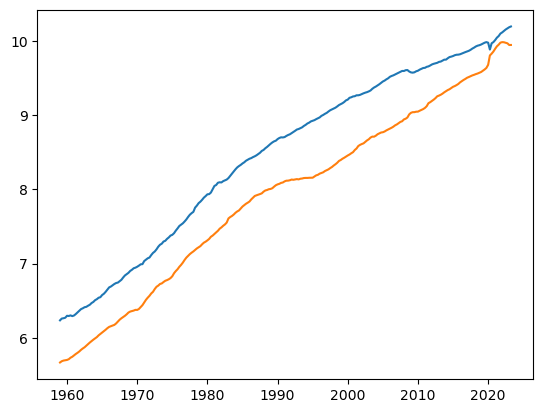

In [5]:
# draw logs of gdp and m2
plt.plot(df['DATE'],np.log(df['GDP']))
plt.plot(df['DATE'],np.log(df['M2SL']))

In [6]:
# descriptive statistics
df[['GDP', 'M2SL']].describe()

,GDP,M2SL
count,258.000000,258.000000
mean,8237.339562,5092.367829
std,7171.633242,5351.473170
min,510.330000,289.200000
25%,1625.050250,934.500000
50%,6081.020000,3336.900000
75%,14339.839750,7248.725000
max,26798.605000,21697.500000


In [7]:
# logs of variables
df[['GDP', 'M2SL']] = np.log(df[['GDP', 'M2SL']])
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
df[['GDP']] = scaler1.fit_transform(df[['GDP']])
df[['M2SL']] = scaler2.fit_transform(df[['M2SL']])

In [8]:
# add lags
for i in range(1, 5):
    df[f'GDP_Lag{i}'] = df['GDP'].shift(i)
    df[f'M2_Lag{i}'] = df['M2SL'].shift(i)
df = df.dropna()

In [9]:
# calculate penalty for loss function
n = df.shape[0]
pen = 1/np.array(range(n+1, 0, -1))

In [10]:
# Create model structure
model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(3, activation="relu"),
    #tf.keras.layers.Dense(3, activation="tanh"),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', loss_weights=pen)

In [11]:
X = df.drop(columns=['GDP', 'M2SL', 'DATE'])
y = df['GDP']
y.index = range(0, y.shape[0])

In [12]:
# train_test_samplle
test_obs = 2
y_train = y[range(0, df.shape[0]-test_obs)].copy()
X_train = X.iloc[range(0, df.shape[0]-test_obs),:].copy()
y_test = y[range(df.shape[0]-test_obs, df.shape[0])].copy()
X_test = X.iloc[range(df.shape[0]-test_obs, df.shape[0]),:].copy()

In [13]:
# set seed
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    print(f"Random seed set as {seed}")

In [14]:
set_seed()
%time model.fit(X_train, y_train)

Random seed set as 42
8/8 [==============================] - 0s 3ms/step - loss: 0.0026
CPU times: total: 297 ms
Wall time: 417 ms


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 27        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [16]:
p = np.exp(scaler1.inverse_transform(model.predict(X_test)))
y_test = np.exp(scaler1.inverse_transform(np.array(y_test).reshape(1, -1)))
print(mean_absolute_percentage_error(y_test.reshape(-1, 1), p.reshape(-1, 1)))

1/1 [==============================] - 0s 132ms/step
0.0523653295753332


In [17]:
result_array = np.concatenate((p.reshape(-1, 1), y_test.reshape(-1, 1)), axis=1)
print(result_array)

[[25264.33007812 26529.774     ]
 [25270.23632812 26798.605     ]]


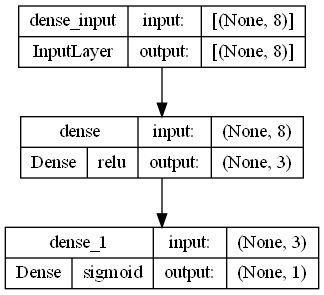

In [18]:
plot_model(model,show_shapes=True, show_layer_names=True,show_layer_activations=True )